<a href="https://colab.research.google.com/github/samuel-oluwemimo/programming_pytorch_for_deep_learning/blob/main/R_V00_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 01 Download dataset from kaggle




In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oluwemimoayodeji","key":"0df098a9cfa45df618eb6bfd439670f0"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mattop/panda-or-bear-image-classification

Dataset URL: https://www.kaggle.com/datasets/mattop/panda-or-bear-image-classification
License(s): CC0-1.0
 94% 11.0M/11.7M [00:00<00:00, 48.2MB/s]
100% 11.7M/11.7M [00:00<00:00, 50.7MB/s]


In [4]:
!unzip panda-or-bear-image-classification.zip

Archive:  panda-or-bear-image-classification.zip
  inflating: PandasBears/Test/Bears/251.jpeg  
  inflating: PandasBears/Test/Bears/252.jpeg  
  inflating: PandasBears/Test/Bears/253.jpeg  
  inflating: PandasBears/Test/Bears/254.jpeg  
  inflating: PandasBears/Test/Bears/255.jpeg  
  inflating: PandasBears/Test/Bears/256.jpeg  
  inflating: PandasBears/Test/Bears/257.jpeg  
  inflating: PandasBears/Test/Bears/258.jpeg  
  inflating: PandasBears/Test/Bears/259.jpeg  
  inflating: PandasBears/Test/Bears/260.jpeg  
  inflating: PandasBears/Test/Bears/261.jpeg  
  inflating: PandasBears/Test/Bears/262.jpeg  
  inflating: PandasBears/Test/Bears/263.jpeg  
  inflating: PandasBears/Test/Bears/264.jpeg  
  inflating: PandasBears/Test/Bears/265.jpeg  
  inflating: PandasBears/Test/Bears/266.jpeg  
  inflating: PandasBears/Test/Bears/267.jpeg  
  inflating: PandasBears/Test/Bears/268.jpeg  
  inflating: PandasBears/Test/Bears/269.jpeg  
  inflating: PandasBears/Test/Bears/270.jpeg  
  inflating

#### -002 preparing our dataset (image preprocessing & image loading)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms as transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [6]:
train_dataset_path = '/content/PandasBears/Train'
test_dataset_path = '/content/PandasBears/Test'

In [7]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
train = torchvision.datasets.ImageFolder(
    root=train_dataset_path, transform=transforms
)

In [8]:
train_size = int(0.8 * len(train))
val_size = len(train) - train_size

In [9]:
train_dataset, val_dataset = random_split(train, [train_size, val_size])

In [10]:
test_dataset = torchvision.datasets.ImageFolder(
    root=test_dataset_path, transform=transforms
)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Building our NeuralNetwork

In [30]:
class skyNet(nn.Module):
    def __init__(self):
        super(skyNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

skyNet = skyNet()


In [31]:
optimizer = optim.Adam(skyNet.parameters(), lr=0.001)

In [32]:
import torch
import torch.nn.functional as F

def model_train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=0):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input, target = batch
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        num_correct = 0
        num_examples = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input, target = batch
                output = model(input)
                loss = loss_fn(output, target)
                val_loss += loss.item()
                correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], target).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
        val_loss /= len(val_dataloader)

        print("Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy: {:.2f}".format(
            epoch, train_loss, val_loss, num_correct / num_examples))


In [33]:
model_train(skyNet,train_dataloader,val_dataloader,loss_fn=nn.CrossEntropyLoss(),optimizer=optimizer,epochs=50)

Epoch: 0, Training Loss: 0.45, Validation Loss: 0.03, Accuracy: 0.99
Epoch: 1, Training Loss: 0.14, Validation Loss: 0.01, Accuracy: 1.00
Epoch: 2, Training Loss: 0.09, Validation Loss: 0.01, Accuracy: 1.00
Epoch: 3, Training Loss: 0.03, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 4, Training Loss: 0.05, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 5, Training Loss: 0.02, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 6, Training Loss: 0.03, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 7, Training Loss: 0.03, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 8, Training Loss: 0.03, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 9, Training Loss: 0.00, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 10, Training Loss: 0.01, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 11, Training Loss: 0.00, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 12, Training Loss: 0.01, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 13, Training Loss: 0.00, Validation Loss: 0.00, Accuracy: 1.00
Epoch: 14, Training Loss: 0.01

In [34]:
from torchvision import datasets

# Load the dataset
dataset = datasets.ImageFolder(root='/content/PandasBears/Train')

# Print the class-to-index mapping
print(dataset.class_to_idx)


{'Bears': 0, 'Pandas': 1}


panda


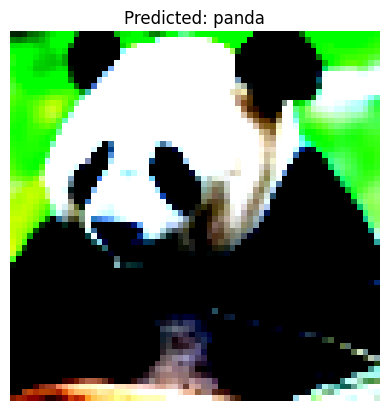

In [40]:
import matplotlib.pyplot as plt
from PIL import Image

labels = ['bear','panda']
img = Image.open('/content/PandasBears/Test/Pandas/271.jpeg')
img = transforms(img)
img = img.unsqueeze(0)
prediction = skyNet(img)
prediction = prediction.argmax()
print(labels[prediction])
# Visualization
plt.imshow(img.squeeze().permute(1,2,0))
plt.title(f"Predicted: {labels[prediction]}")
plt.axis('off')
plt.show()

In [43]:
torch.save(skyNet.state_dict(), '/content/my_model.pth')